# **Credit Risk Analysis using Machine Learning Models**


# Introduction

The objective of this project is to analyze credit risk by predicting whether a customer will default on their credit card payment in the next month. Credit risk assessment is crucial for financial institutions to minimize losses and make informed lending decisions. This analysis uses machine learning models to evaluate customer data and predict default probability, improving decision-making accuracy.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. Imports**

In [4]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime.lime_tabular

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# **2. Load Dataset**

In [5]:
# 2. Load Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, skiprows=1)
df.rename(columns={"default payment next month": "default"}, inplace=True)
df.drop(columns=["ID"], inplace=True)
print(df.shape)
df.head()


(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# **3. Exploratory Data Analysis (EDA)**

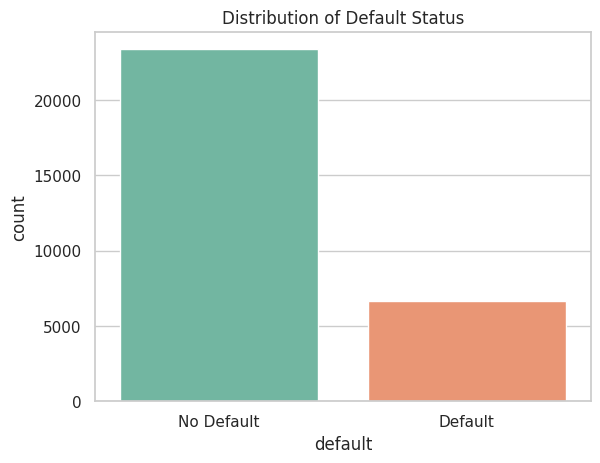

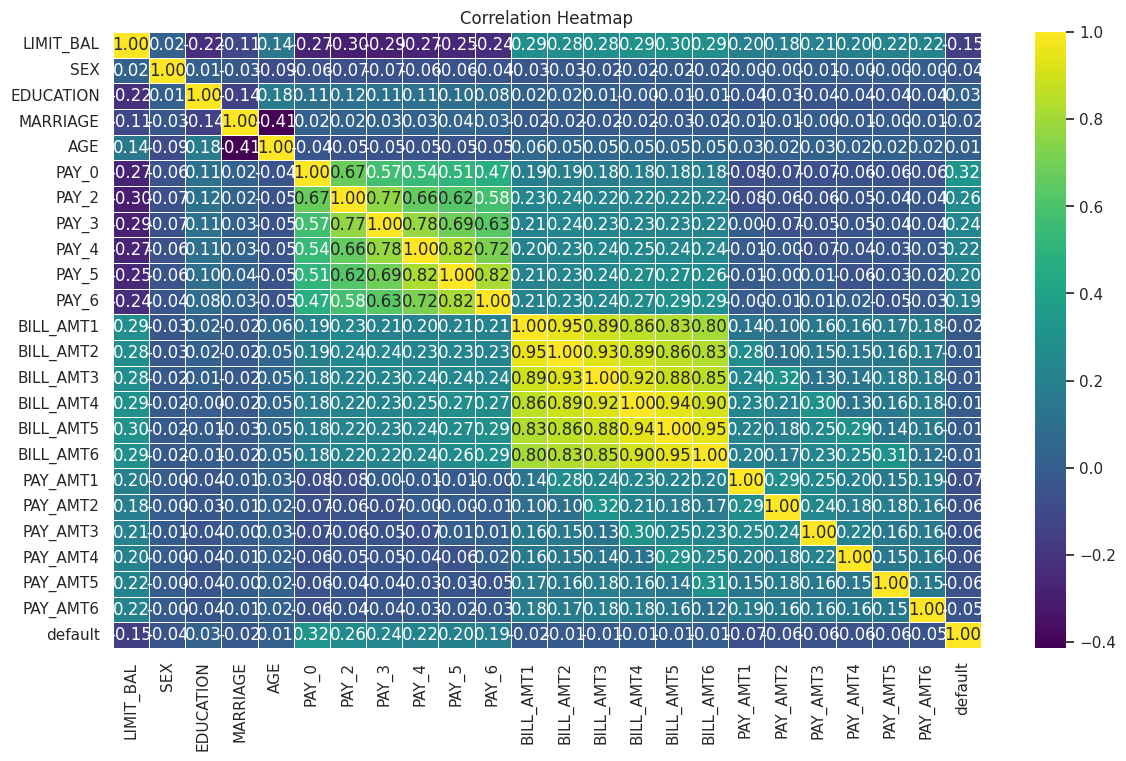

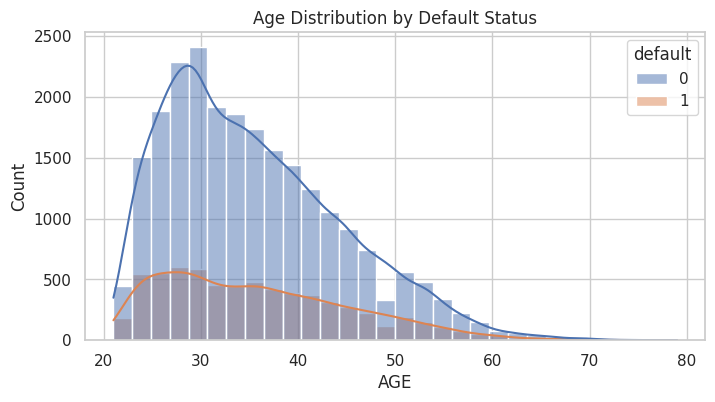

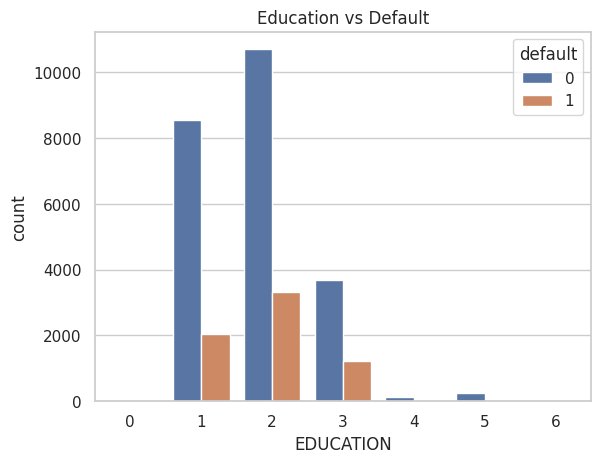

In [6]:
# 3. EDA
# Target variable distribution
sns.countplot(x='default', data=df, palette='Set2')
plt.title("Distribution of Default Status")
plt.xticks([0, 1], ['No Default', 'Default'])
plt.show()

# Correlation Heatmap
plt.figure(figsize=(14, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Age vs Default
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="AGE", hue="default", bins=30, kde=True)
plt.title("Age Distribution by Default Status")
plt.show()

# Education vs Default
sns.countplot(data=df, x="EDUCATION", hue="default")
plt.title("Education vs Default")
plt.show()

# **4. Data Preprocessing**

In [7]:
#  4. Preprocessing
def preprocess_data(df):
    """
    Preprocesses dataset: Scaling + SMOTE + Train-Test Split.
    """
    X = df.drop(columns=["default"])
    y = df["default"]

    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # SMOTE
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
    )

    return X_train, X_test, y_train, y_test, scaler

# Preprocess data
X_train, X_test, y_train, y_test, scaler = preprocess_data(df)



# **5. Model Training**

In [8]:
#5. Train Models

def train_models(X_train, y_train):
    """
    Trains multiple ML models.
    """
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
        "XGBoost": XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42),
        "Naive Bayes": GaussianNB()
    }
    for name, model in models.items():
        model.fit(X_train, y_train)
    return models

# Train models
models = train_models(X_train, y_train)


# **6. Model Evaluation with Visual Confusion Matrices**


Logistic Regression
Accuracy: 0.6734431842499465
F1 Score: 0.6704578174488914
Confusion Matrix:
 [[4784 2226]
 [2352 4657]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.68      0.68      7010
           1       0.68      0.66      0.67      7009

    accuracy                           0.67     14019
   macro avg       0.67      0.67      0.67     14019
weighted avg       0.67      0.67      0.67     14019



<Figure size 1000x600 with 0 Axes>

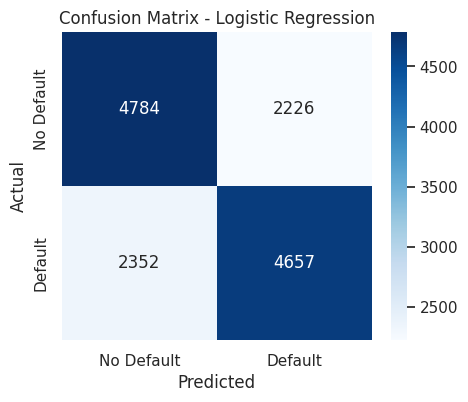


Random Forest
Accuracy: 0.7664598045509665
F1 Score: 0.746712053226056
Confusion Matrix:
 [[5919 1091]
 [2183 4826]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.84      0.78      7010
           1       0.82      0.69      0.75      7009

    accuracy                           0.77     14019
   macro avg       0.77      0.77      0.77     14019
weighted avg       0.77      0.77      0.77     14019



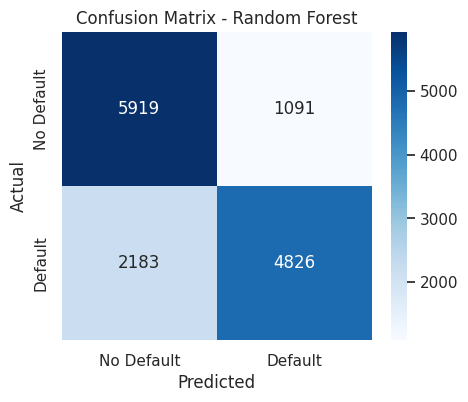


XGBoost
Accuracy: 0.7933518795919823
F1 Score: 0.7769651243359766
Confusion Matrix:
 [[6076  934]
 [1963 5046]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81      7010
           1       0.84      0.72      0.78      7009

    accuracy                           0.79     14019
   macro avg       0.80      0.79      0.79     14019
weighted avg       0.80      0.79      0.79     14019



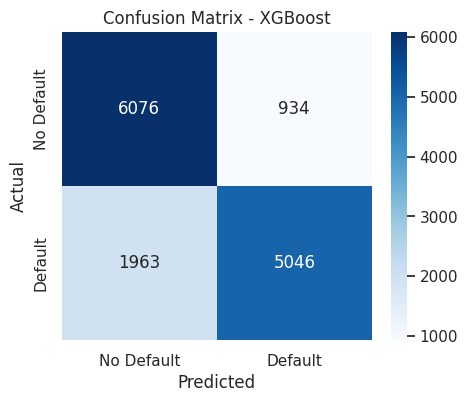


Naive Bayes
Accuracy: 0.6009701119908696
F1 Score: 0.6874161823871257
Confusion Matrix:
 [[2274 4736]
 [ 858 6151]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.32      0.45      7010
           1       0.56      0.88      0.69      7009

    accuracy                           0.60     14019
   macro avg       0.65      0.60      0.57     14019
weighted avg       0.65      0.60      0.57     14019



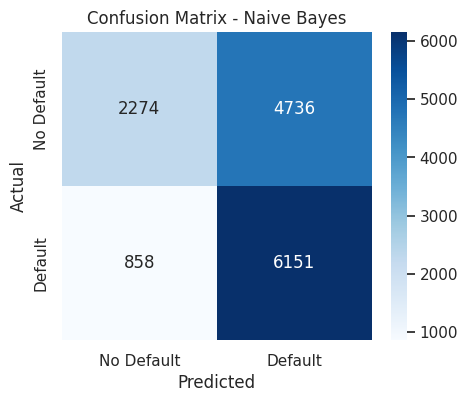

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.673443,0.676595,0.664431,0.670458,0.733401
1,Random Forest,0.766460,0.815616,0.688543,0.746712,0.846811
2,XGBoost,0.793352,0.843813,0.719932,0.776965,0.871270
3,Naive Bayes,0.600970,0.564986,0.877586,0.687416,0.737446


In [9]:
#  6. Evaluate Models with Visual Confusion Matrices

def evaluate_models(models, X_test, y_test):
    """
    Evaluates models: prints metrics, confusion matrices, ROC AUC.
    """
    results = []
    plt.figure(figsize=(10, 6))

    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
        cm = confusion_matrix(y_test, y_pred)

        print(f"\n{name}")
        print("Accuracy:", acc)
        print("F1 Score:", f1)
        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n", classification_report(y_test, y_pred))

        # Confusion Matrix Plot
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["No Default", "Default"],
                    yticklabels=["No Default", "Default"])
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # Save results
        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "ROC AUC": roc_auc
        })

    results_df = pd.DataFrame(results)
    display(results_df)
    return results_df

# Evaluate
evaluation_df = evaluate_models(models, X_test, y_test)




# **7. Cross-Validation Comparison**

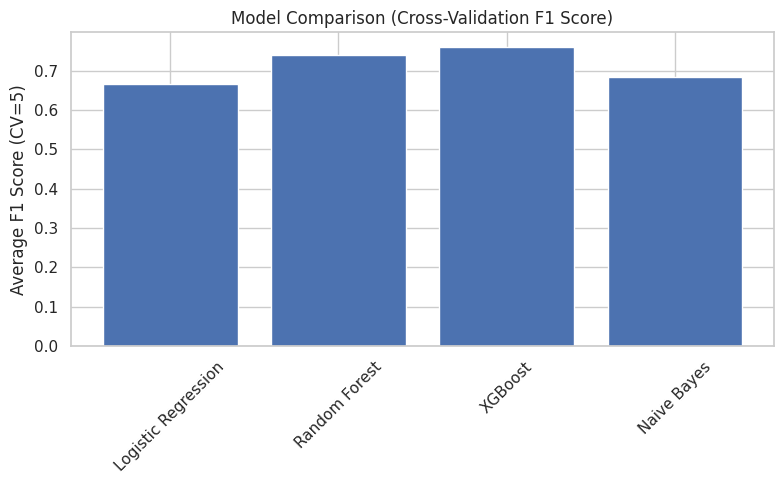

In [10]:
 #7. Cross-Validation F1 Scores
cv_scores = {}
f1_scores = []
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(StandardScaler().fit_transform(df.drop(columns=["default"])), df["default"])

for name, model in models.items():
    pipe = Pipeline([('model', model)])
    scores = cross_val_score(pipe, X_resampled, y_resampled, scoring='f1', cv=5)
    cv_scores[name] = scores
    f1_scores.append(scores.mean())

plt.figure(figsize=(8, 5))
plt.bar(cv_scores.keys(), f1_scores)
plt.ylabel('Average F1 Score (CV=5)')
plt.title('Model Comparison (Cross-Validation F1 Score)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **8. ROC Curve Plotting**

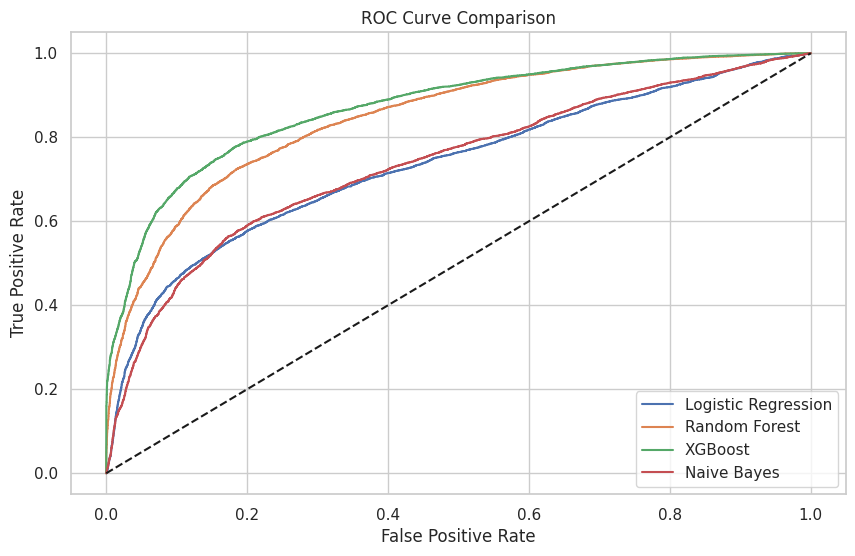

In [11]:
#  8. ROC Curve Plotting

def plot_roc_curves(models, X_test, y_test):
    """
    Plots ROC curves for each model.
    """
    plt.figure(figsize=(10, 6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, label=f"{name}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curves(models, X_test, y_test)


# **9. Model Interpretation (SHAP + LIME)**

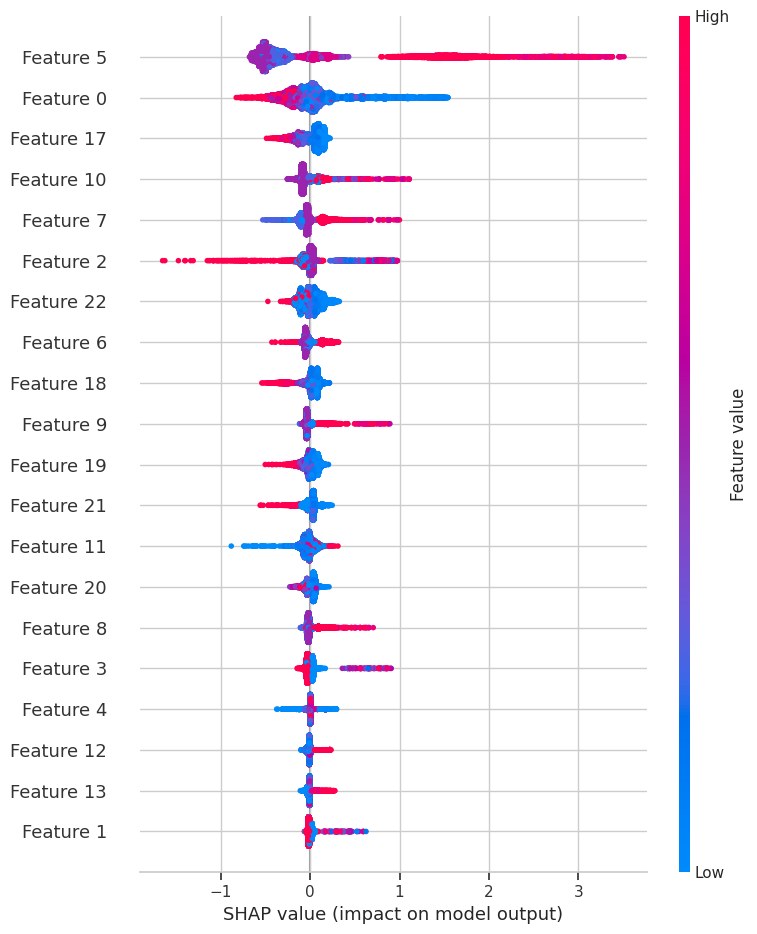

In [17]:
# 9. Model Interpretation

def shap_explain(model, X_sample):
    """
    SHAP summary plot for a model.
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    shap.summary_plot(shap_values, X_sample)

shap_explain(models["XGBoost"], X_test)



In [18]:
def lime_explain(model, X_train, X_test, feature_names):
    """
    LIME explanation for a single prediction.
    """
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=feature_names,
        class_names=["No Default", "Default"],
        mode='classification'
    )
    exp = explainer.explain_instance(X_test[0], model.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True)

# Get the feature names from the original DataFrame
feature_names = df.drop(columns=["default"]).columns.tolist()

lime_explain(models["XGBoost"], X_train, X_test, feature_names=feature_names)


# **10. Final Prediction Summary**

Final Prediction Summary:
No Default (0)    8039
Default (1)       5980
Name: count, dtype: int64


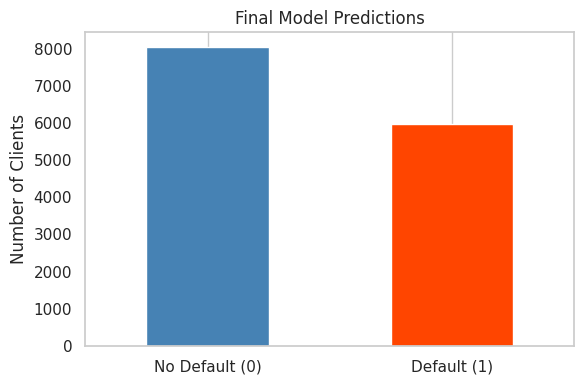

In [14]:
# 10. Final prediction summary
def final_prediction_summary(models, X_test):
    """
    Final prediction counts and bar plot.
    """
    final_predictions = models["XGBoost"].predict(X_test)
    prediction_counts = pd.Series(final_predictions).value_counts().sort_index()
    prediction_counts.index = ['No Default (0)', 'Default (1)']

    print("Final Prediction Summary:")
    print(prediction_counts)

    plt.figure(figsize=(6, 4))
    prediction_counts.plot(kind='bar', color=['steelblue', 'orangered'])
    plt.title("Final Model Predictions")
    plt.ylabel("Number of Clients")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

final_prediction_summary(models, X_test)


# **11. Model Saving**

In [15]:
# 11. Save Best Models
joblib.dump(models["XGBoost"], "xgboost_model.pkl")
joblib.dump(models["Random Forest"], "random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Models saved successfully.")


Models saved successfully.
